<a href="https://colab.research.google.com/github/AllanBottino/Series_Temporais_Python/blob/main/ARIMA_S%C3%A9ries_Temporais_Parte_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 14.0MB/s 
     |████████████████████████████████| 9.5MB 33.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from pandas import DataFrame
import itertools
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from math import sqrt
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima #!pip install pmdarima

import warnings
warnings.filterwarnings('ignore')

# Analise exploratória dos dados (EDA)

In [3]:
from google.colab import files
uploaded = files.upload()

Saving GLD.csv to GLD.csv


In [227]:
import io

df_original = pd.read_csv(io.BytesIO(uploaded['GLD.csv']))

print(df_original.head())

         Date       Open       High        Low      Close  Adj Close    Volume
0  2004-11-18  44.430000  44.490002  44.070000  44.380001  44.380001   5992000
1  2004-11-19  44.490002  44.919998  44.470001  44.779999  44.779999  11655300
2  2004-11-22  44.750000  44.970001  44.740002  44.950001  44.950001  11996000
3  2004-11-23  44.880001  44.919998  44.720001  44.750000  44.750000   3169200
4  2004-11-24  44.930000  45.049999  44.790001  45.049999  45.049999   6105100


In [228]:
print(df_original.info(),"\n")
print(df_original.describe())
print(df_original.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3780 entries, 0 to 3779
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3780 non-null   object 
 1   Open       3780 non-null   float64
 2   High       3780 non-null   float64
 3   Low        3780 non-null   float64
 4   Close      3780 non-null   float64
 5   Adj Close  3780 non-null   float64
 6   Volume     3780 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 206.8+ KB
None 

              Open         High  ...    Adj Close        Volume
count  3780.000000  3780.000000  ...  3780.000000  3.780000e+03
mean    109.298553   109.854220  ...   109.297146  9.677284e+06
std      33.461304    33.575604  ...    33.458163  7.196708e+06
min      41.029999    41.360001  ...    41.259998  3.193000e+05
25%      87.362501    88.407503  ...    87.419998  5.089775e+06
50%     117.024998   117.444999  ...   116.985000  7.992400e+06
75%     127.002

In [229]:
print("A data deste dataframe vai de: " + (df_original['Date'].min()) + " até:" + (df_original['Date'].max()))

A data deste dataframe vai de: 2004-11-18 até:2019-11-22


# Conclusão EDA

Faltam dados, por exemplo os preços das ações estão ausentes em dias sem negociação, como fins de semana e feriados
vamos reamostrar as datas e usar o preenchimento progressivo para preencher os valores ausentes no dataframe.

In [230]:
# Vamos carregar o arquivo, passar a coluna "Date" para o formato datetime(parse_date) e colocar
# a coluna Date como indice (index_col).
ffill_df = pd.read_csv(io.BytesIO(uploaded['GLD.csv']), parse_dates=['Date'], index_col=['Date'])

# Tamanho do arquivo:
print("GLD Data Antes do Preenchimento: " + str(ffill_df.shape),"\n")

print(ffill_df.head())

GLD Data Antes do Preenchimento: (3780, 6) 

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2004-11-18  44.430000  44.490002  44.070000  44.380001  44.380001   5992000
2004-11-19  44.490002  44.919998  44.470001  44.779999  44.779999  11655300
2004-11-22  44.750000  44.970001  44.740002  44.950001  44.950001  11996000
2004-11-23  44.880001  44.919998  44.720001  44.750000  44.750000   3169200
2004-11-24  44.930000  45.049999  44.790001  45.049999  45.049999   6105100


In [231]:
# Vamos reamostrar os dados por dia ("D") e nisso vamos usar o método ffil()
# para lidar com os dados nulos que irão aparecer.
# https://www.geeksforgeeks.org/python-pandas-dataframe-ffill/

ffill_df = ffill_df.resample("D").ffill()

In [232]:
print("GLD DF depois do ffil(): " + str(ffill_df.shape),"\n")
print(ffill_df.head())

GLD DF depois do ffil(): (5483, 6) 

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2004-11-18  44.430000  44.490002  44.070000  44.380001  44.380001   5992000
2004-11-19  44.490002  44.919998  44.470001  44.779999  44.779999  11655300
2004-11-20  44.490002  44.919998  44.470001  44.779999  44.779999  11655300
2004-11-21  44.490002  44.919998  44.470001  44.779999  44.779999  11655300
2004-11-22  44.750000  44.970001  44.740002  44.950001  44.950001  11996000


# EDA Conclusão:

- O arquivo csv original costumava ter 3.780 linhas de dados. Depois de preencher as datas ausentes, agora temos 5.483 linhas de dados.

# Visualizando o arquivo:

GLD Preços de todos os dias, inclusive finais de semana e feriados: (5483, 6) 

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2004-11-18  44.430000  44.490002  44.070000  44.380001  44.380001   5992000
2004-11-19  44.490002  44.919998  44.470001  44.779999  44.779999  11655300
2004-11-20  44.490002  44.919998  44.470001  44.779999  44.779999  11655300
2004-11-21  44.490002  44.919998  44.470001  44.779999  44.779999  11655300
2004-11-22  44.750000  44.970001  44.740002  44.950001  44.950001  11996000


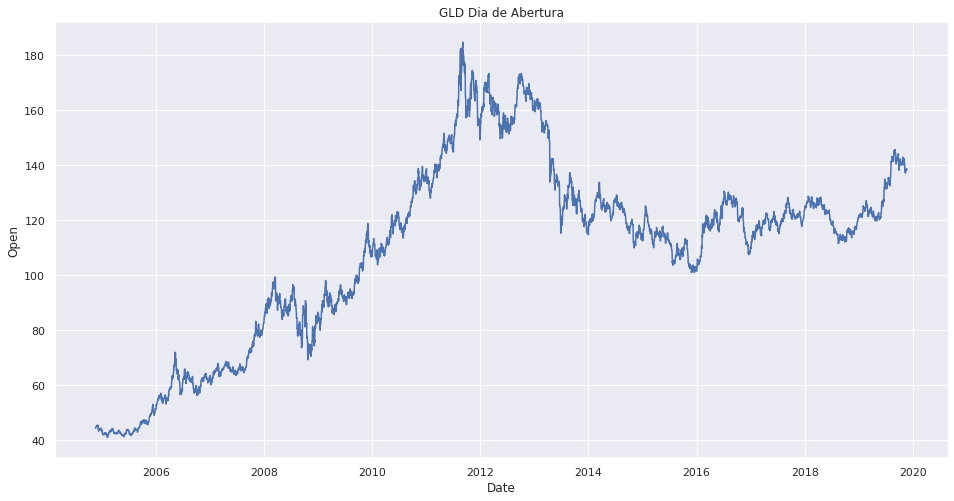

In [233]:
df1 = pd.read_csv(io.BytesIO(uploaded['GLD.csv']), parse_dates=['Date'], index_col=['Date'])

# O sort_index colocou os dados em ordem, o resto vocês já sabem.
df1 = df1.sort_index().resample("D").ffill()

print("GLD Preços de todos os dias, inclusive finais de semana e feriados: " + str(df1.shape),"\n")
print(df1.head())

# Vamos ver o dia de abertura(Open)
sns.set(style="darkgrid")
plt.figure(figsize=(16,8))
sns.lineplot(x=df1.index, y='Open', data=df1, linewidth=1.5).set_title('GLD Dia de Abertura')
plt.show()

# Teste de estacioridade:

Antes de entrarmos propriamente no ARIMA, antes vou fazer o teste de Dickey-Fuller, depois vou transformar essa série temporal em estacionária, e enquanto transformamos em estacionária encontramos o valor(d) do ARIMA.

Aqui neste artigo eu falo um pouco mais do teste de Dickey-Fuller:

https://www.linkedin.com/pulse/decomposi%C3%A7%C3%A3o-de-s%C3%A9ries-temporais-e-valida%C3%A7%C3%A3o-com-teste-allan-bottino/

In [234]:
adfuller_result = adfuller(df1['Open'])
print('ADF Statistic: ', adfuller_result[0])
print('p-value: ', adfuller_result[1])

ADF Statistic:  -1.802517498171303
p-value:  0.37921254390714443


### Como podem ver, o p-value é maior que 0,05 (5%), ou seja ele não é estacionário.

# Transformando a Série Temporal em estacionária:

Vamos usar o método "diff()", ou seja a diferenciação entre os valores para para tornar estacionário a série, em outras palavras, vamos usar o diff uma vez(diff(1)), se uma diferenciação for suficiente para tornar a série temporal estacionária, então nosso ARIMA ter o d = 1. Caso não seja usaremos o diff(2) ou diff().diff(), quantas vezes for necessário até o p-value for aceitável (menos de 5%).

Depois vamos ver o erro médio quadrático 

Método diff():

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html

Vamos começar usando o diff() uma só vez e ver se é suficiente:

In [235]:
# Como já fizemos acima vamos criar uma variável nova, e colocar o método diff() nele,
# depois o "dropna()" deleta os arquivos NaN que são gerados pela diferenciação.
df1_diff = df1.diff().dropna()

# E aqui fazemos novamente o teste de Dickey-Fuller para ver o p-value
diff_adfuller_result = adfuller(df1_diff['Open'])
print('Diferenciação sobre o ADF Statistic: ', diff_adfuller_result[0])
print('Diferenciação sobre o p-value: ', diff_adfuller_result[1])

Diferenciação sobre o ADF Statistic:  -16.738250093306696
Diferenciação sobre o p-value:  1.3650617859603262e-29


In [236]:
# Diferenciação duas vezes:
df1_difftwice = df1.diff().diff().dropna()
difftwice_adfuller_result = adfuller(df1_difftwice['Open'])
print('Diferenciação sobre o ADF Statistic: ', difftwice_adfuller_result[0])
print('Diferenciação sobre o p-value: ', difftwice_adfuller_result[1])

Diferenciação sobre o ADF Statistic:  -21.13672510562612
Diferenciação sobre o p-value:  0.0


### Conclusão:

Depois de usar a primeira diferenciação:  uma e duas vezes produziram um valor p menor que 0,05, mas Diferenciar duas vezes produziu uma estatística ADF muito mais negativa. É isso que queremos, quanto mais negativo, melhor.

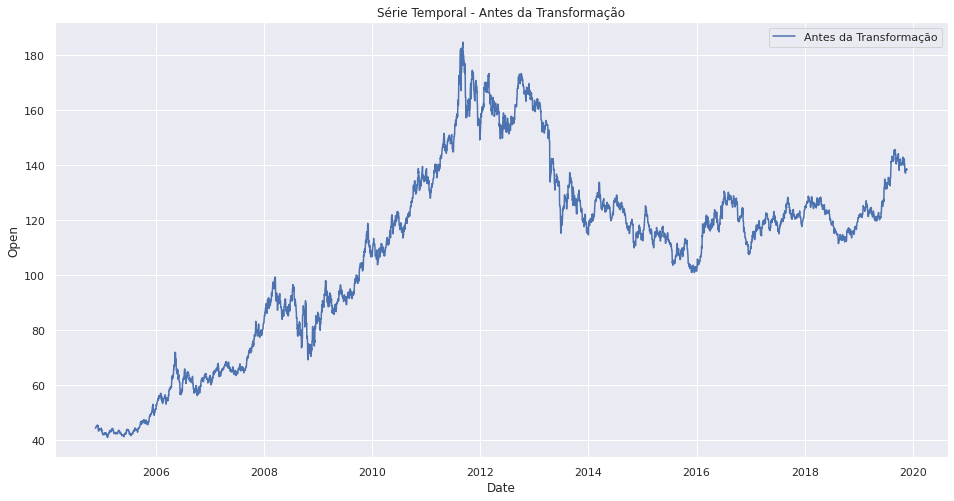

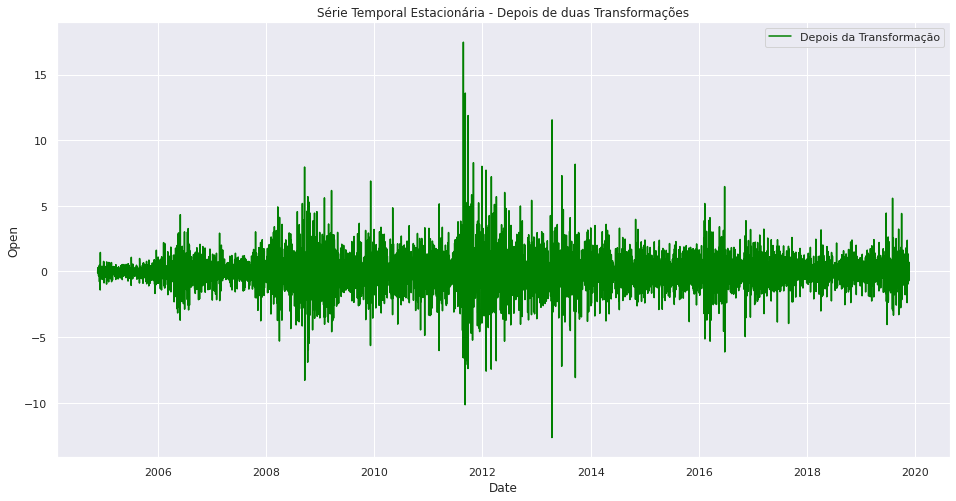

In [237]:
# Plotando antes da Transformação:
plt.figure(figsize=(16,8))
sns.lineplot(x=df1.index, y='Open', data=df1, linewidth=1.5, label='Antes da Transformação').set_title('Série Temporal - Antes da Transformação')
plt.show()

# Plotando depois da Transformação:
plt.figure(figsize=(16,8))
sns.lineplot(x=df1_difftwice.index, y='Open', data=df1_difftwice, label='Depois da Transformação', color='green').set_title('Série Temporal Estacionária - Depois de duas Transformações')
plt.show()

# Train-test Split/ Dividindo o dataset

Dividindo o dataset:

Eu não falei sobre dividir o data set nos outros artigos pois não achei necessário, aqui tentarei explicar e mostrar da maneira mais simples possível.

Por que dividir o dataset?

R: Dividimos em dados de treino e teste, para dar ao modelo um conjunto de informações para aprender, por exemplo, queremos que o programa aprenda o que é um gato, então damos milhões de imagens para o algoritmo dizendo que tal coisa é um gato, então depois de muito o algoritmo aprender com os padrões do que é um gato (dados de treino), ele então faz um teste (dados de teste) e então se a acurácia, for (por exemplo) acima de 95% o programa está indo bem, dá para usar ele, se não, o que faltou? Precisamos aumentar o conjunto de treino para ele ter mais informações? Mudar o algorimo? Mexer em algum outro detalhe?

Resimidamente e simplistamente é isso. Estamos dando o máximo de informações para o modelo aprender, ter o máximo de referências possíveis.

Neste Data-set nós temos 15 anos de dados. Usaremos os primeiros 12 anos (2004 - 2016) como dados de treinamento e os últimos 3 anos (2017 - 2019) como dados de teste.

In [238]:
train_data = df1.loc[:'2016']
test_data = df1.loc['2017':]

print(train_data.shape,"\n")
print(test_data.shape,"\n")

# Vamos ver se o arquivo termina em 2016 mesmo...
print(train_data.tail(2),"\n")

# E vamos ver se o arquivo começa em 2017 mesmo...
print(test_data.head(2))

(4427, 6) 

(1056, 6) 

                  Open        High         Low       Close   Adj Close   Volume
Date                                                                           
2016-12-30  110.379997  110.620003  109.529999  109.610001  109.610001  8873700
2016-12-31  110.379997  110.620003  109.529999  109.610001  109.610001  8873700 

                  Open        High         Low       Close   Adj Close   Volume
Date                                                                           
2017-01-01  110.379997  110.620003  109.529999  109.610001  109.610001  8873700
2017-01-02  110.379997  110.620003  109.529999  109.610001  109.610001  8873700


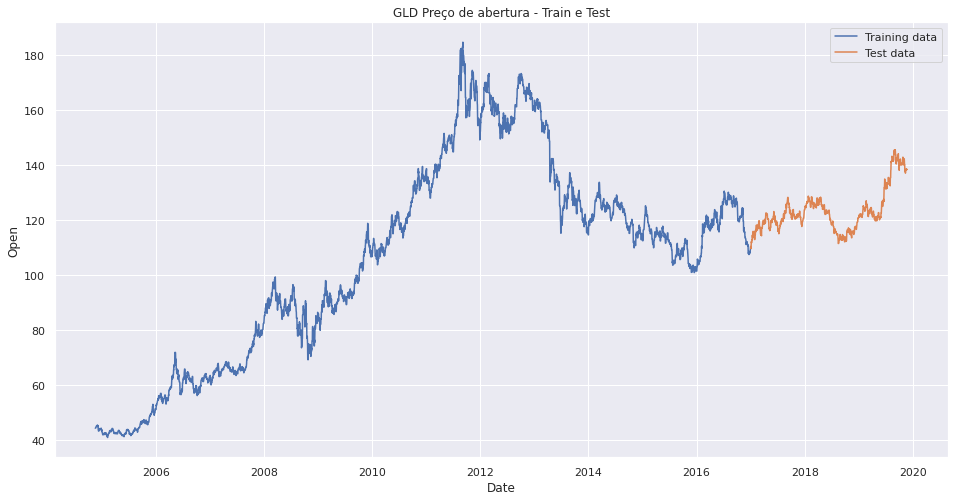

In [239]:
# Plotando os dados de treino e test:
plt.figure(figsize=(16,8))
sns.lineplot(x=train_data.index, y='Open', data=train_data, linewidth=1.5, label='Training data').set_title('GLD Preço de abertura - Train e Test')
sns.lineplot(x=test_data.index, y='Open', data=test_data, linewidth=1.5, label='Test data')
plt.show()

#Criando o primeiro modelo ARIMA.

Lá encima nós usamos o comando diff() para fazer as diferenciações necessárias, para abaixar o valor p e tornar a série temporal estacionária, mas quando usamos o comando que irá fazer a previsão, nós não precisamos fazer essa diferenciação, o próprio comando fará tudo.

### Relembrando:

- p = número de defasagens autoregressivas
- d = ordem de diferenciação
- q = número de defasagens médias móveis

Vamos começar usando:

- d = 2
- p = 0
- q = 1

Eu estarei usando a biblioteca:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Ou seja, estarei usando o SARIMAX ao invés do ARIMA, pois essa biblioteca tem mais opções do que a biblioteca do ARIMA, e o que difere o ARIMA do SARIMAX é que o SARIMAX tem um termo a mais, no caso a sasonalidade, mas eu vou me ater aos 3 primeiros valores (p, d, q).


In [240]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Treinaremos o modelo com os dados que treino que separamos acima, especificamente a coluna "Open".
model = SARIMAX(train_data['Open'], order=(1,2,1), trend= 'c')

# Iremos armazenar o modelo treinado (model.fit()) dentro de "results".
results = model.fit()

# Aqui vamos usar o comando "get_prediction" sobre o results (onde está armazenado os nossos resultados)
# e colocar tudo dentro de: "pred_365_traindata" e dentro dele estará o resultado  
# de 365 dias.
#"dynamic = False" garante que produzamos previsões um passo à frente, as previsões em cada ponto são geradas
# usando o histórico completo até aquele ponto
# start = -365, queremos começar a previsão de um ano atrás (365 dias), ou seja, queremos que ele
# faça a previsão recuando 365 dias dentro dele mesmo (por isso o sinal de menos).
pred_365_traindata = results.get_prediction(start=-365, dynamic= False)

# E com o comando ".predicted_mean" nós podemos ver e acessar o arquivo sem colocar ele no dataframa ou converter ele
# com o comando ".Series" e ao mesmo tempo ver a média.
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.base.prediction.PredictionResults.html
pred_mean_365_traindata = pred_365_traindata.predicted_mean

In [241]:
# Aqui vemos a quantidade de arquivos:
print(pred_mean_365_traindata.shape, "\n")

# Aqui vemos a previsão sobre os 365 dias:
print(pred_mean_365_traindata.head(365))

(365,) 

Date
2016-01-02    101.449963
2016-01-03    101.449951
2016-01-04    101.449940
2016-01-05    103.090983
2016-01-06    103.100451
                 ...    
2016-12-27    107.807613
2016-12-28    108.573424
2016-12-29    108.368979
2016-12-30    109.193253
2016-12-31    110.341757
Freq: D, Name: predicted_mean, Length: 365, dtype: float64


In [242]:
# Vamos criar uma variável e colocar dentro dele a predição.
train_data['forecasted_mean_365'] = pred_mean_365_traindata

# Vou usar o comando loc para selecionar do começo de 2016 até o final para vermos (pois o df é grande.)
print(train_data.loc["2016-01-01" : "2017-01-01"].head(367))

# O primeiro NaN é do valor "p" que está em 1.

                  Open        High  ...   Volume  forecasted_mean_365
Date                                ...                              
2016-01-01  101.480003  101.720001  ...  3823600                  NaN
2016-01-02  101.480003  101.720001  ...  3823600           101.449963
2016-01-03  101.480003  101.720001  ...  3823600           101.449951
2016-01-04  103.129997  103.669998  ...  6440000           101.449940
2016-01-05  103.129997  103.459999  ...  3500300           103.090983
...                ...         ...  ...      ...                  ...
2016-12-27  108.610001  108.669998  ...  3685500           107.807613
2016-12-28  108.400002  108.910004  ...  5091200           108.573424
2016-12-29  109.230003  110.529999  ...  7563900           108.368979
2016-12-30  110.379997  110.620003  ...  8873700           109.193253
2016-12-31  110.379997  110.620003  ...  8873700           110.341757

[366 rows x 7 columns]


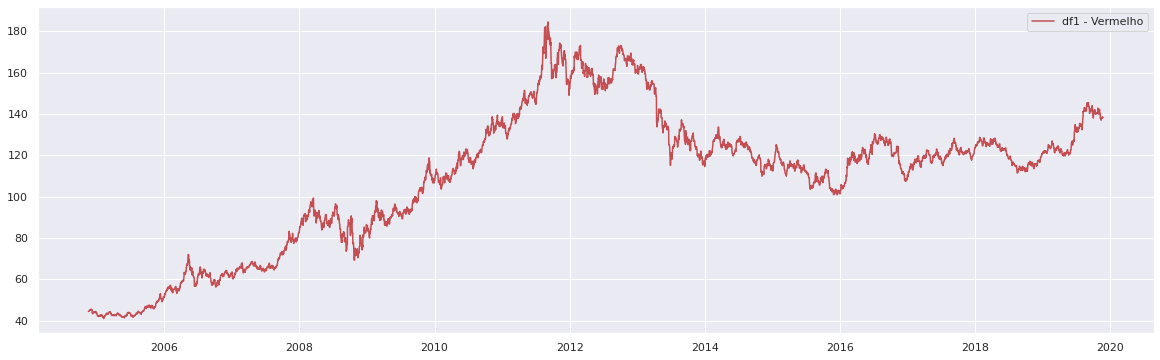

In [243]:
# Plotando o arquivo orginal:
plt.figure(figsize=(20, 6))
plt.plot(df1.Open, "r-")

# Colocando as legendas:
plt.legend(['df1 - Vermelho'])

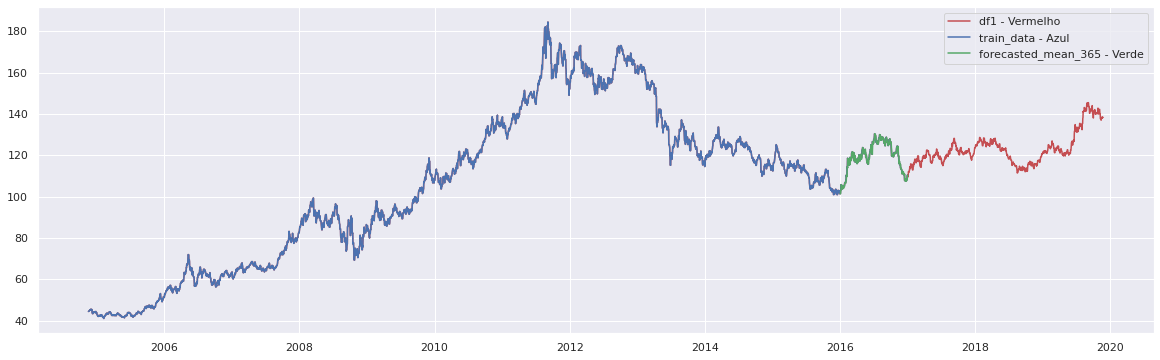

In [244]:
# Configurando o tamanho das telas:
plt.figure(figsize=(20, 6))

# Plotando a série original em vermelho:
plt.plot(df1.Open, "r-")

# Plotando o arquivo de treino (train_data) em azul:
plt.plot(train_data.Open, "b-")

# Plotando o modelo que treinamos (gorecasted_mean_365) em verde:
plt.plot(train_data.forecasted_mean_365, "g-")

# Colocando as legendas:
plt.legend(['df1 - Vermelho', "train_data - Azul", 'forecasted_mean_365 - Verde'])

Até que não ficou mal não? A previsão que fizemos foi sobre 365 dias sobre os dados de treino, ou seja fizemos a previsão regredindo um ano nos arquivos, que no caso é a tela verde. Se compararmos o primeiro gráfico (os dados originais) com o segundo, podemos ver que pelo menos visualmente falando, não ficou muito ruim, mas vamos continuar analisando:


# Cálculos MAE, MSE, RMSE
- Erro Médio Absoluto - Mede a magnitude média dos erros em um conjunto de previsões, sem considerar sua direção. Ele mede a precisão para variáveis contínuas. Valores mais baixos são melhores, 0 é melhor.

- Erro Quadrático Médio (MSE) - A diferença quadrática média entre os valores estimados e o que é estimado. Mede a qualidade de um estimador. Quanto menor o MSE, mais perto estamos de encontrar a linha de melhor ajuste.

- Root Mean Square Error (RMSE) - Semelhante ao MSE, porém, a diferença média quadrática entre os valores estimados e o que é estimado.

In [245]:
# Usando algumas bibliotecas do sklearn para calcular os erros:
print('MAE: {}'.format(mean_absolute_error(real_values, pred_mean_365_traindata)))
print('MSE: {}'.format(mean_squared_error(real_values, pred_mean_365_traindata)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(real_values, pred_mean_365_traindata))))

MAE: 0.6351378577570745
MSE: 1.0435447527074353
RMSE: 1.021540382318504


#Auto-ARIMA

In [246]:
# Vamos deixar só a coluna "Open" aqui dentro:
arima_data = df1.drop(columns=['High', 'Low', 'Close', 'Adj Close', 'Volume'])
print(arima_data.head())

                 Open
Date                 
2004-11-18  44.430000
2004-11-19  44.490002
2004-11-20  44.490002
2004-11-21  44.490002
2004-11-22  44.750000


In [247]:
# Referências - http://www.alkaline-ml.com/pmdarima/0.9.0/modules/generated/pyramid.arima.auto_arima.html
# "Seasonal = True" por padrão, caso não houvesse o "seasonal=False" ele iria automaticamente
# procurar o valor "s" para esse modelo.
# "stepwise = True" Para identificar os parâmetros ideais do modelo
# "trace = True" Serve paraver os resultados embaixo.
# "error_action='ignore'" Serve para ignorar possíveis mensagens de erros.
# start é de onde vamos começar os testes e max é até onde vai os testes até achar os melhores parametros.

results = auto_arima(arima_data,
                    seasonal=False,
                    start_p = 1,
                    start_d = 1,
                    start_q = 1,
                    max_P=3,
                    max_D=3,
                    max_Q= 3,
                    information_criterion='aic',
                    trace=True,
                    error_action='ignore',
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15867.129, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15863.338, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15865.223, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15865.225, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15862.861, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.509 seconds


In [248]:
# dividindo o arquivo:
auto_arima_train_data = arima_data.loc[:'2016']
auto_arima_test_data = arima_data.loc['2017':]

# Criando o modelo com as métricas que a célula de cima nos passou (0,1,0)
auto_arima_model = SARIMAX(auto_arima_train_data, seasonal=False, order=(0,1,0))

# Treinando o modelo (.fit()):
auto_arima_results = auto_arima_model.fit() 

# Aqui eu uso o comando para fazer a previsão sobre os 365 dias (get_prediction)
auto_arima_pred_365_traindata = auto_arima_results.get_prediction(start=-365, dynamic=False)

auto_arima_pred_365_traindata = auto_arima_pred_365_traindata.predicted_mean

# E assim como fiz encima vou guardar a predição dentro dos dados de treino.
auto_arima_train_data['Auto_Arima_forecasted_mean_365'] = auto_arima_pred_365_traindata

# E aqui vamos ver:
print(auto_arima_train_data.loc["2016-01-01" : "2017-01-01"].head(367))

                  Open  Auto_Arima_forecasted_mean_365
Date                                                  
2016-01-01  101.480003                             NaN
2016-01-02  101.480003                      101.480003
2016-01-03  101.480003                      101.480003
2016-01-04  103.129997                      101.480003
2016-01-05  103.129997                      103.129997
...                ...                             ...
2016-12-27  108.610001                      107.839996
2016-12-28  108.400002                      108.610001
2016-12-29  109.230003                      108.400002
2016-12-30  110.379997                      109.230003
2016-12-31  110.379997                      110.379997

[366 rows x 2 columns]


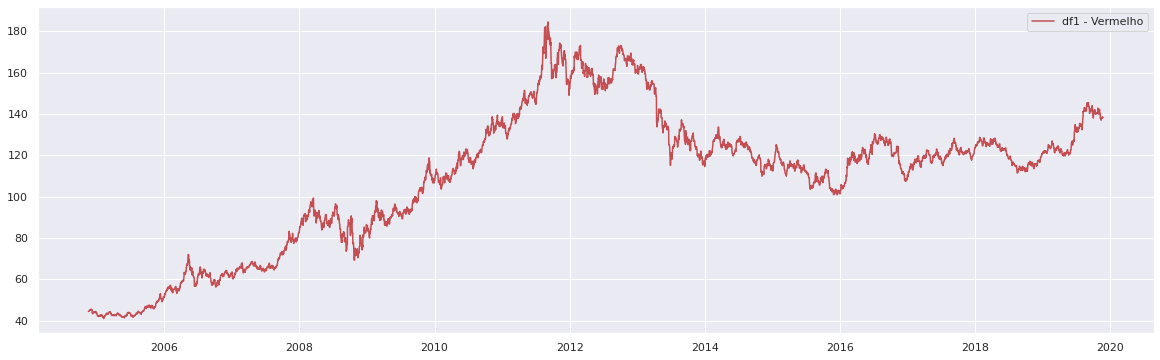

In [249]:
# Plotando o arquivo orginal:
plt.figure(figsize=(20, 6))
plt.plot(df1.Open, "r-")

# Colocando as legendas:
plt.legend(['df1 - Vermelho'])

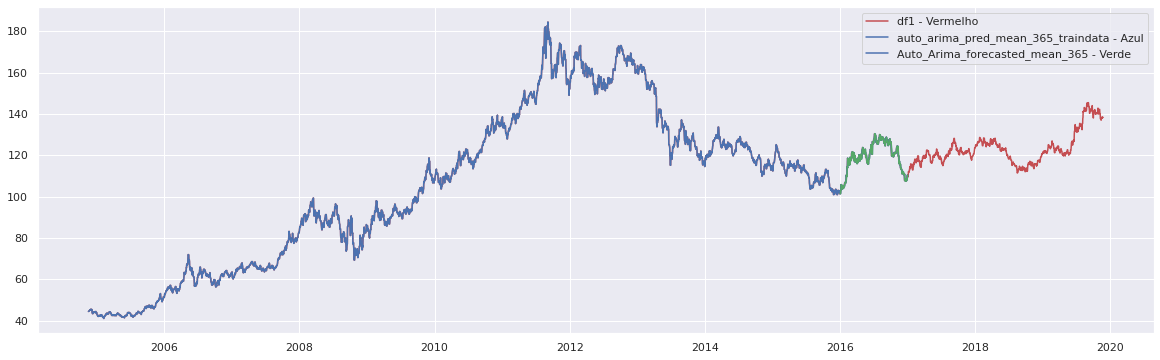

In [250]:
# Configurando o tamanho das telas:
plt.figure(figsize=(20, 6))

# Plotando a série original em vermelho:
plt.plot(df1.Open, "r-")

# Plotando o arquivo de treino (train_data) em azul:
plt.plot(auto_arima_train_data, "b-")

# Plotando o modelo que treinamos (gorecasted_mean_365) em verde:
plt.plot(auto_arima_train_data.Auto_Arima_forecasted_mean_365, "g-")

# Colocando as legendas:
plt.legend(['df1 - Vermelho', "auto_arima_pred_mean_365_traindata - Azul", 'Auto_Arima_forecasted_mean_365 - Verde'])

In [251]:
# Calculando o MAE, MSE, RMSE
print('MAE: {}'.format(mean_absolute_error(real_values, auto_arima_pred_365_traindata)))
print('MSE: {}'.format(mean_squared_error(real_values, auto_arima_pred_365_traindata)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(real_values, auto_arima_pred_365_traindata))))

MAE: 0.6267396493150685
MSE: 1.041826541598619
RMSE: 1.020699045555848


# Resultados:

**Arima:**
- MAE: 0.64
- MSE: 1.04
- RMSE: 1.02


**Auto-Arima:**
- MAE: 0.62
- MSE: 1.04
- RMSE: 1.02

Como podemos ver a diferença foi pouca, mas houve, o auto-arima encontrou os melhores parâmetros (0,1,0) e obteve o melhor resultado MAE: 0.62.

# Auto-Arima para prever dois anos no futuro!

Aqui eu vou usar o modelo SARIMAX não apenas o ARIMA, a diferença é que no SARIMAX terá a componente sazonal, a sazonalidade dos dados. A previsão não será perfeita (nenhuma é) mas se nós levarmos em consideração o sobe e desce do gráfico, poderemos ver para que lado (possívelmente) vai (ou sobe ou desce), que seria a sazonalidade.

In [252]:
# Criaremos o modelo como fizemos antes, mas aqui eu vou deixar 
# a sazonalidade (s) junto, ou seja vamos usar um modelo SARIMAX
# quem sabe os resultados melhorem.
all_auto_arima_model = SARIMAX(arima_data, seasonal=True, order=(0,1,0),
                               seasonal_order=(0,0,0,7), trend='c')

# Treinando o modelo (.fit()):
all_auto_arima_results = all_auto_arima_model.fit() 

# Número de dias a serem previstos:
forecast_days = 365 * 2

# Também poderiamos colocar 730 dias para a previsão, mas deixa assim.
all_auto_arima_forecast = all_auto_arima_results.get_forecast(steps=forecast_days)

# E novamente com o comando ".predicted_mean" nós conseguimos ver o arquivo (a média)
all_auto_arima_mean_forecast = all_auto_arima_forecast.predicted_mean

print(all_auto_arima_mean_forecast.head())

2019-11-23    138.387131
2019-11-24    138.404267
2019-11-25    138.421403
2019-11-26    138.438539
2019-11-27    138.455675
Freq: D, Name: predicted_mean, dtype: float64


In [253]:
# O arquivo começa em 2004-11-18 e vai até 2019-11-22, mas nós queremos que 
# a previsão até 2021-11-21 e esse será o end_date.
# Tem que colocar tudo no formato detetime.
import datetime
start_date = datetime.datetime.strptime("2004-11-18", "%Y-%m-%d")
end_date = datetime.datetime.strptime("2021-11-21", "%Y-%m-%d")

# Aqui fazemos a predição com as datas que escolhemos:
pred_all = all_auto_arima_results.get_prediction(start=start_date, end=end_date, dynamic=False)

# Aqui tiramos a média da predição:
pred_2 = pred_all.predicted_mean

# Eu normalmente colocaria o resultado da previsão dentro dos
# dados de treino, mas aqui não aconteceu isso, então vamos
# usar o comando to_frame (https://pandas.pydata.org/docs/reference/api/pandas.Series.to_frame.html)
pred_2 = pred_2.to_frame(name='Predicted_2_Years')
print(pred_2.tail())

            Predicted_2_Years
2021-11-17         150.810790
2021-11-18         150.827926
2021-11-19         150.845062
2021-11-20         150.862198
2021-11-21         150.879334


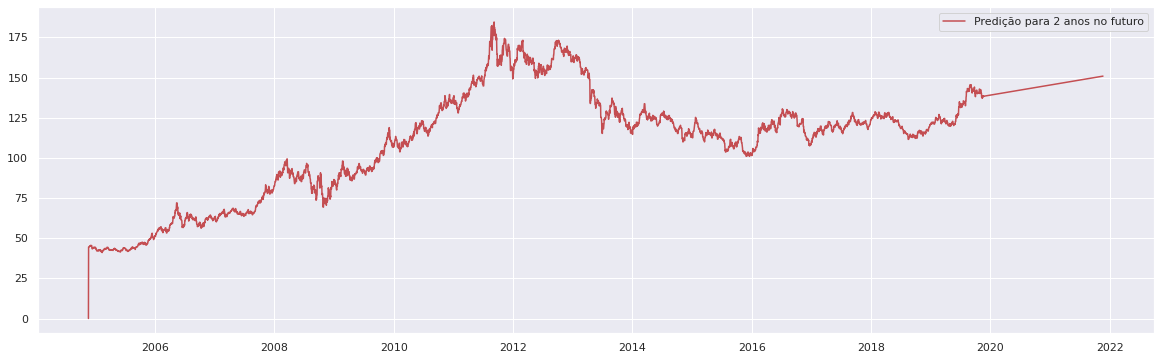

In [254]:
# Configurando o tamanho das telas:
plt.figure(figsize=(20, 6))

# Plotando o modelo que treinamos (pred_2) em vermelho:
plt.plot(pred_2, "r-")

# Colocando as legendas:
plt.legend(['Predição para 2 anos no futuro'])

# Conclusão:

Conclusão:
Com os modelos arima, auto-arima e sarimax, e com os parâmetros que usamos e ainda com a quantidade de dados que nós tínhamos disponível, a previsão que conseguimos fazer foi essa que podemos ver no gráfico, muito provavelmente outros modelos poderiam ser melhores e até estes que usamos podiam ter seus hiper parâmetros mais bem configurados, mas com esse último modelo conseguimos prever onde provavelmente a linha de tendência dessa série irá estar (graças a sazonalidade).
Essa não é uma previsão perfeita, mas mostra bem os comandos e a linha de raciocínio do processo.
Abraços.
